In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, TargetEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
import torch

In [2]:
#Тестирование разных кластеров на успешность разделения выборки по accident_risk
def findBestCluster(data, cluster_model, threshold):
    X = data.drop('accident_risk', axis=1)
    y = data['accident_risk']

    columns_combinations = []
    for next_col in X.columns[:4]:
        append_combinations = []
        for prev_combination in columns_combinations:
            next_combination = list(prev_combination)
            next_combination.append(next_col)
            append_combinations.append(next_combination)
        columns_combinations.extend(append_combinations)
        columns_combinations.append([next_col])
    columns_combinations = list(filter(lambda x: len(x)>1, columns_combinations))

    result = (float('-inf'), [])
    for cluster_columns in columns_combinations:
        cluster_data = pd.get_dummies(X[cluster_columns])
        cluster_model.fit(cluster_data)
        cluster_label = cluster_model.labels_.astype(bool)
        cluster_accuracy = np.sum((y>threshold)==cluster_label) / y.shape[0]
        result = max(result, (cluster_accuracy, cluster_columns))
    return result

In [3]:
class TreeBoostingTrainer:
    def __init__(self, model, model_params, grid_search_gap=5, min_data_part=0.5):
        self.model = model
        self.model_params = model_params
        self.grid_search_gap = grid_search_gap
        self.min_data_part = min_data_part

    def _getParamStartVal(self, value):
        return 2 * value // (self.grid_search_gap + 1)
    
    def _getParamsBiasArray(self, epochs):
        params_bias = {}
        for param, value in self.model_params.items():
            bias_arr = [self._getParamStartVal(value)]
            if epochs > 1:
                delim = np.power(bias_arr[-1], 1/(epochs-1))
                for _ in range(epochs-1):
                    bias_arr.append(bias_arr[-1]/delim)
            bias_arr = deque(map(lambda x: int(np.round(x)), bias_arr))
            params_bias[param] = bias_arr
        
        result = []
        for _ in range(epochs):
            bias_dict = {}
            for param, bias_arr in params_bias.items():
                bias_dict[param] = bias_arr.popleft()
            result.append(bias_dict)
        return result
    
    def _getGridParams(self, params_bias):
        result = {}
        for param, bias in params_bias.items():
            values = [max(1, self.model_params[param]-bias*(self.grid_search_gap//2))]
            for _ in range(self.grid_search_gap-1):
                values.append(values[-1]+bias)
            result[param] = values 
        return result

    @staticmethod
    def train_model(model, df_train, target_column):
        X = df_train.drop(target_column, axis=1)
        y = df_train[target_column] 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        print(f'Параметры: {model.best_params_}')
        print(f'Ошибка модели = {root_mean_squared_error(y_test, y_predict)}')
    
    def train(self, df_train, epochs, target_column, scoring, verbose=0):
        data_part_perc = np.linspace(self.min_data_part, 1, epochs)
        params_bias_array = self._getParamsBiasArray(epochs)
        for part_perc, params_bias in zip(data_part_perc, params_bias_array):
            df_train_part = df_train.iloc[np.random.choice(list(range(df_train.shape[0])),
                                                           size=int(df_train.shape[0]*part_perc),
                                                           replace=False)]
            grid_params = self._getGridParams(params_bias)
            print(f'Параметры сетки\n{grid_params}')
            print(f'Размер данных ({np.round(part_perc*100, 2)}%)\n{df_train_part.shape}')
            grid_model = GridSearchCV(self.model, grid_params, scoring=scoring, cv=5, verbose=verbose)
            self.train_model(grid_model, df_train_part, target_column)
            self.model_params = grid_model.best_params_

In [4]:
#Загрузка данных
df_train_origin = pd.read_csv('train.csv', index_col='id')
df_test_origin = pd.read_csv('test.csv', index_col='id')
df_full = pd.concat([df_train_origin, df_test_origin], axis=0)

In [8]:
#Пропусков нет
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 690339 entries, 0 to 690338
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               690339 non-null  object 
 1   num_lanes               690339 non-null  int64  
 2   curvature               690339 non-null  float64
 3   speed_limit             690339 non-null  int64  
 4   lighting                690339 non-null  object 
 5   weather                 690339 non-null  object 
 6   road_signs_present      690339 non-null  bool   
 7   public_road             690339 non-null  bool   
 8   time_of_day             690339 non-null  object 
 9   holiday                 690339 non-null  bool   
 10  school_season           690339 non-null  bool   
 11  num_reported_accidents  690339 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 55.3+ MB


In [5]:
#Признаки
#road_type - тип дороги (трасса, городская, деревенская)
#num_lanes - кол-ов полос на участке
#curvature - кривизна дороги (повороты): от 0(прямая) до 1(оч. извилистая)
#speed_limit - ограничение скорости (миль/час)
#lighting - освещение в моменте (дневной свет, ночь, тускло)
#weather - погода в моменте (ясно, дождливо, туман)
#road_signs_present - есть ли дорожные знаки на участке
#public_road - частная или общественная дорога
#time_of_day - время суток (утро, день, ночь)
#holiday - праздник ли в моменте
#school_season - школьная пора в моменте
#num_reported_accidents - кол-во подтвержденных проишествий на участке к моменту

<Axes: >

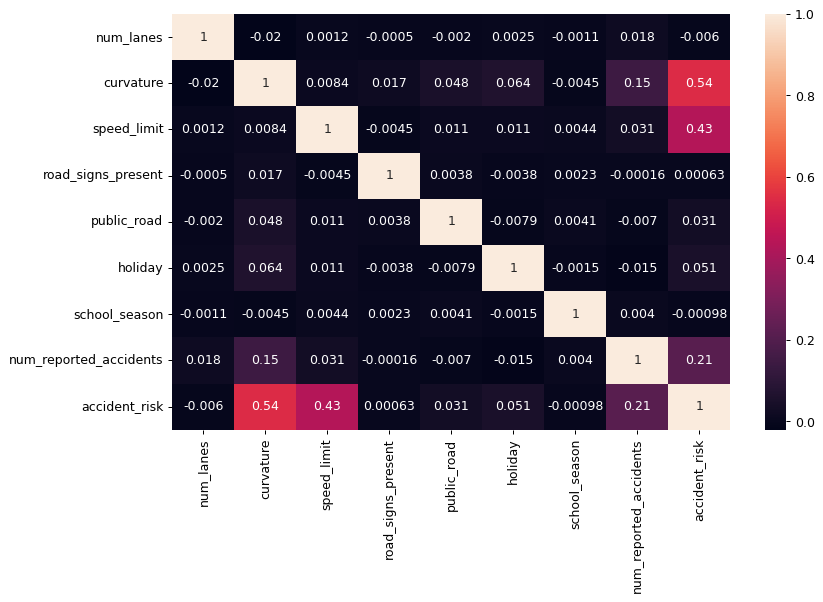

In [7]:
#Корреляция признаков (скоростное ограничение, извилистость и зарегистрированные происшествия)
df_corr = df_train_origin.drop(['road_type','lighting','weather','time_of_day'], axis=1).corr()
plt.figure(figsize=(10,6), dpi=90)
sns.heatmap(df_corr, annot=True)

In [ ]:
#I. Создание новых признаков:
#   1. На основе road_type создать признак Город (True, False) (НЕ УЛУЧШАЕТ)
#   2. Сделать num_lanes, speed_limit категориальным (НЕ УЛУЧШАЕТ)
#   3. Сделать Target Encoding на категориальные признаки (НЕ УЛУЧШАЕТ)
#   4. Сделать кластеры (НЕ УЛУЧШАЕТ)
#II. Ансамбль моделей
#   1. Для Обучения, Тестирования и Валидации использовать одни и те же данные для всех моделей
#   2. Обучить разные модели и записать их результаты в качестве признаков
#   3. Обучить финальную модель на этих признаках и target = accident_risk

In [22]:
#II. Будем обучать несколько моделей, результаты их работы используем как признаки для обучения Нейронной сети

In [11]:
#XGBoost
#Лучшие параметры: {'model__max_leaves': 17, 'model__n_estimators': 379}
df_training = pd.get_dummies(df_train_origin)
xgboost_model = XGBRegressor()
pipe_model = Pipeline([('model', xgboost_model)])
model_params = {'model__n_estimators': 500,
                'model__max_leaves': 12}
trainer = TreeBoostingTrainer(pipe_model, model_params, 7)
trainer.train(df_training, 5, 'neg_root_mean_squared_error', 'accident_risk')

Параметры сетки
{'model__n_estimators': [125, 250, 375, 500, 625, 750, 875], 'model__max_leaves': [3, 6, 9, 12, 15, 18, 21]}
Размер данных
(258877, 21)
Параметры: {'model__max_leaves': 12, 'model__n_estimators': 375}
Ошибка модели = 0.056096502276740755
Параметры сетки
{'model__n_estimators': [264, 301, 338, 375, 412, 449, 486], 'model__max_leaves': [6, 8, 10, 12, 14, 16, 18]}
Размер данных
(323596, 21)
Параметры: {'model__max_leaves': 16, 'model__n_estimators': 412}
Ошибка модели = 0.056152833266806854
Параметры сетки
{'model__n_estimators': [379, 390, 401, 412, 423, 434, 445], 'model__max_leaves': [10, 12, 14, 16, 18, 20, 22]}
Размер данных
(388315, 21)
Параметры: {'model__max_leaves': 16, 'model__n_estimators': 379}
Ошибка модели = 0.05627150799035638
Параметры сетки
{'model__n_estimators': [370, 373, 376, 379, 382, 385, 388], 'model__max_leaves': [13, 14, 15, 16, 17, 18, 19]}
Размер данных
(453034, 21)
Параметры: {'model__max_leaves': 18, 'model__n_estimators': 379}
Ошибка модели =

In [5]:
#CatBoost
#Лучшие параметры: {'model__depth': 9, 'model__iterations': 423}
Параметры: {'model__depth': 9, 'model__iterations': 423}
df_training = pd.DataFrame(df_train_origin)
catboost_model = CatBoostRegressor(learning_rate=0.1, 
                                   cat_features=['road_type','lighting','weather','time_of_day'],
                                   verbose=0)
pipe_model = Pipeline([('model', catboost_model)])
grid_params = {'model__iterations': [423],
                'model__depth': [9]}
grid_model = GridSearchCV(pipe_model, grid_params, scoring='neg_root_mean_squared_error', cv=5, verbose=2)
trainer = TreeBoostingTrainer(None, None)
trainer.train_model(grid_model, df_training, 'accident_risk')

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] END ..............model__depth=7, model__iterations=417; total time=  29.1s
[CV] END ..............model__depth=7, model__iterations=417; total time=  29.1s
[CV] END ..............model__depth=7, model__iterations=417; total time=  28.7s
[CV] END ..............model__depth=7, model__iterations=417; total time=  28.8s
[CV] END ..............model__depth=7, model__iterations=417; total time=  29.2s
[CV] END ..............model__depth=7, model__iterations=418; total time=  28.6s
[CV] END ..............model__depth=7, model__iterations=418; total time=  29.9s
[CV] END ..............model__depth=7, model__iterations=418; total time=  28.8s
[CV] END ..............model__depth=7, model__iterations=418; total time=  28.8s
[CV] END ..............model__depth=7, model__iterations=418; total time=  28.9s
[CV] END ..............model__depth=7, model__iterations=419; total time=  28.2s
[CV] END ..............model__depth=7, model__i

In [10]:
#LightGBM
#Лучшие параметры: {'model__n_estimators': 78, 'model__num_leaves': 96}
df_training = pd.get_dummies(df_train_origin)
lgbm_model = LGBMRegressor(verbose=0)
pipe_model = Pipeline([('model', lgbm_model)])
model_params = {'model__n_estimators': 500,
                'model__num_leaves': 50}
trainer = TreeBoostingTrainer(pipe_model, model_params, 7, 0.7)
trainer.train(df_training, 5, 'accident_risk', 'neg_root_mean_squared_error', 2)

Параметры сетки
{'model__n_estimators': [125, 250, 375, 500, 625, 750, 875], 'model__num_leaves': [14, 26, 38, 50, 62, 74, 86]}
Размер данных (70.0%)
(362427, 21)
Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV] END ......model__n_estimators=125, model__num_leaves=14; total time=   0.4s
[CV] END ......model__n_estimators=125, model__num_leaves=14; total time=   0.4s
[CV] END ......model__n_estimators=125, model__num_leaves=14; total time=   0.4s
[CV] END ......model__n_estimators=125, model__num_leaves=14; total time=   0.4s
[CV] END ......model__n_estimators=125, model__num_leaves=14; total time=   0.4s
[CV] END ......model__n_estimators=125, model__num_leaves=26; total time=   0.4s
[CV] END ......model__n_estimators=125, model__num_leaves=26; total time=   0.4s
[CV] END ......model__n_estimators=125, model__num_leaves=26; total time=   0.5s
[CV] END ......model__n_estimators=125, model__num_leaves=26; total time=   0.5s
[CV] END ......model__n_estimators=125, model_

In [5]:
#Обучение моделей ансамбля
X = df_train_origin.drop('accident_risk', axis=1)
X_dummy = pd.get_dummies(X)
y = df_train_origin['accident_risk']
xgboost_model = XGBRegressor(max_leaves=17, n_estimators=379)
xgboost_model.fit(X_dummy, y)

catboost_model = CatBoostRegressor(depth=9,
                                   iterations=423,
                                   learning_rate=0.1, 
                                   cat_features=['road_type','lighting','weather','time_of_day'],
                                   verbose=0)
catboost_model.fit(X, y)

lgbm_model = LGBMRegressor(n_estimators=78, num_leaves=96, verbose=0)
lgbm_model.fit(X_dummy, y);

In [6]:
#Создание данных для ансамбля
X_ensemble = df_full.drop('accident_risk', axis=1)
X_ensemble_dummy = pd.get_dummies(X_ensemble)

y_xgboost = xgboost_model.predict(X_ensemble_dummy)
y_catboost = catboost_model.predict(X_ensemble)
y_lgbm = lgbm_model.predict(X_ensemble_dummy)

df_ensemble = pd.DataFrame({'xgboost': y_xgboost,
                            'catboost': y_catboost,
                            'lgbm': y_lgbm},
                           index=X_ensemble.index)
df_ensemble['target'] = df_full['accident_risk']

In [10]:
#NN Model
class Perceptron(torch.nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 hiden_dim,
                 num_layers):
        super(Perceptron, self).__init__()
        self.layers = torch.nn.Sequential()
        prev_features = in_features
        for layer_no in range(num_layers):
            self.layers.add_module(f'Linear{layer_no+1}',
                                   torch.nn.Linear(prev_features, hiden_dim))
            self.layers.add_module(f'ReLU{layer_no+1}',
                                   torch.nn.ReLU())
            prev_features = hiden_dim
        self.layers.add_module('regression',
                               torch.nn.Linear(prev_features, out_features))

    def forward(self, input):
        return self.layers(input)

def trainer(model, X, y, optimizer, loss_function, epochs):
    for epoch_no in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

In [48]:
#Подготовка данных для Нейронной сети
df_training = df_ensemble.dropna()
X = df_training.drop('target', axis=1)
y = df_training['target']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.from_numpy(X.astype(np.float32).to_numpy())
y_train = torch.from_numpy(y.astype(np.float32).to_numpy()).reshape(-1,1)
#X_test = torch.from_numpy(X_test.astype(np.float32).to_numpy())
#y_test = torch.from_numpy(y_test.astype(np.float32).to_numpy())

#Обучение нейронной сети
epochs = 10000
nn_model = Perceptron(in_features=X_train.shape[1], 
                      out_features=1, 
                      hiden_dim=5, 
                      num_layers=2)

_ = nn_model.train()
trainer(nn_model,  
        X_train,
        y_train,
        torch.optim.Adam(nn_model.parameters()),
        torch.nn.MSELoss(),
        epochs)

with torch.no_grad():
    _ = nn_model.eval()
    y_predict = nn_model(X_train).reshape(-1,)
    error = root_mean_squared_error(y_train, y_predict)
    print(y_predict[:10])
    print(y_train[:10])
    print(f'Ошибка на тесте = {error}\n')

tensor([0.1272, 0.3243, 0.3874, 0.1299, 0.4721, 0.6545, 0.3069, 0.1129, 0.2023,
        0.1166])
tensor([[0.1300],
        [0.3500],
        [0.3000],
        [0.2100],
        [0.5600],
        [0.6100],
        [0.2000],
        [0.1600],
        [0.1800],
        [0.1500]])
Ошибка на тесте = 0.05558803305029869



In [53]:
X_result = df_ensemble[df_ensemble['target'].isna()].drop('target', axis=1)
X_result_tensor = torch.from_numpy(X_result.astype(np.float32).to_numpy())
with torch.no_grad():
    _ = nn_model.eval()
    y_result = nn_model(X_result_tensor).reshape(-1,)
    df_result = pd.DataFrame(y_result, columns=['accident_risk'], index=X_result.index)
    df_result.to_csv('Result.csv', index_label='id')